# Neural network tryouts to produce a image channel's formula learning

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## Let's simulate data such that a sort of NDVI index segments good objects

Let input image have 4 channels, e.g. R,G,B,NIR. Each channel is normalized between [0, 1]. We fill all channels with random uniform noise. However, in R channel pixels of interest will have smaller than average noise values (absorption) and in NIR channel they will have larger than average noise values (emission). 

A NDVI-like image is composed as `(NIR - R) / (NIR + R)`. A binary mask of this NDVI-like image will serve as target image.

In [69]:
n_images = 500
input_height = 80
input_width = 80

inputs = np.random.rand(n_images,4,input_height, input_width) * 0.6 + 0.2
targets = np.zeros((n_images,1,input_height, input_width), dtype=np.uint8)
mean = 0.5

max_size = 10
objects = []

for i in range(n_images):
    
    xs = np.random.randint(1, input_width-max_size)
    xe = xs + np.random.randint(5, max_size)
    ys = np.random.randint(1, input_height-max_size)
    ye = ys + np.random.randint(5, max_size)
    
    objects.append((xs, ys, xe, ye))
    
    inputs[i, 0, ys:ye, xs:xe] = np.clip(inputs[i, 0, ys:ye, xs:xe] - 0.75*mean, 0, 1)
    inputs[i, 3, ys:ye, xs:xe] = np.clip(inputs[i, 3, ys:ye, xs:xe] + 0.85*mean, 0, 1)
    targets[i, 0, ys:ye, xs: xe] = 1

Show first 5 images

Object : (64, 41, 70, 48)
Object : (36, 23, 41, 32)
Object : (53, 2, 60, 9)
Object : (44, 7, 53, 14)
Object : (42, 28, 48, 37)


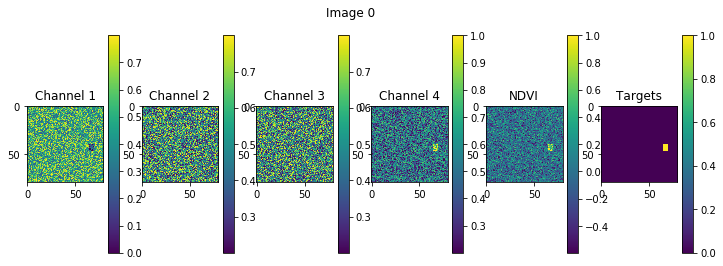

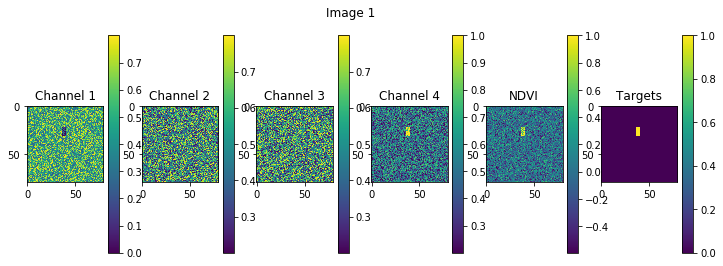

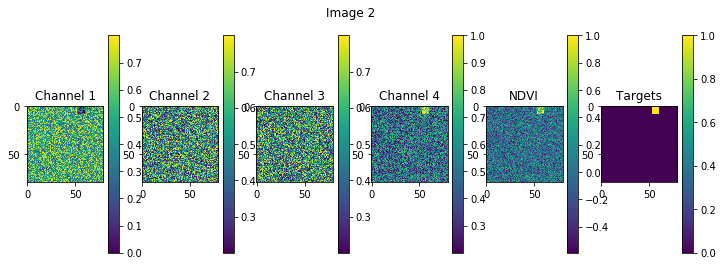

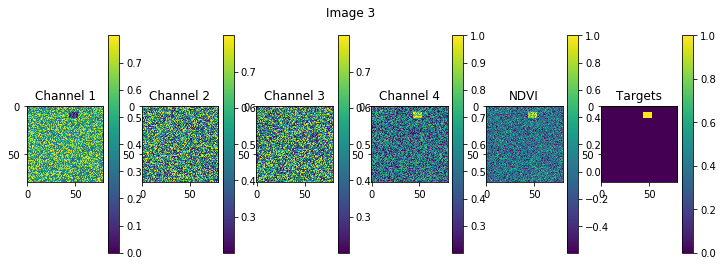

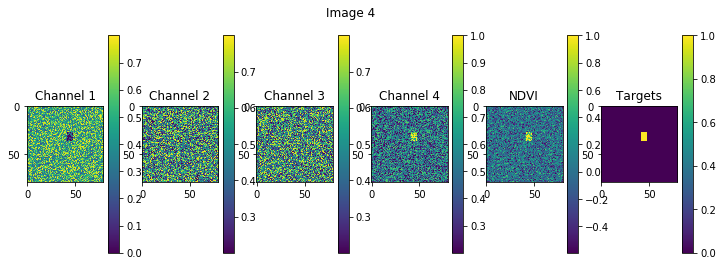

In [70]:
for j in range(5):
    print("Object : {}".format(objects[j]))
    plt.figure(figsize=(12,4))
    plt.suptitle("Image %i" % j)
    for i in range(inputs.shape[1]):
        plt.subplot(1,6,i+1)
        plt.imshow(inputs[j,i,:,:], interpolation='none')
        plt.colorbar()
        plt.title("Channel %s" % str(i+1))
    ndvi = (inputs[j,3,:,:] - inputs[j,0,:,:]) / (inputs[j,3,:,:] + inputs[j,0,:,:])
    plt.subplot(1,6,5)
    plt.imshow(ndvi, interpolation='none')
    plt.colorbar()
    plt.title("NDVI")
    plt.subplot(1,6,6)
    plt.imshow(targets[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Targets")

In [71]:
ll = int(n_images * 0.75)
X_train = inputs[:ll,:,:,:]
X_test  = inputs[ll:,:,:,:]
Y_train = targets[:ll,:,:,:]
Y_test = targets[ll:,:,:,:]
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(375L, 4L, 80L, 80L) (125L, 4L, 80L, 80L) (375L, 1L, 80L, 80L) (125L, 1L, 80L, 80L)


## Define an neural network architecture

### Small U-net like network
Let's take a small U-net like network to learn and predict targets

In [72]:
import theano
from keras.backend import image_dim_ordering
print theano.config.device
print image_dim_ordering()

gpu0
th


In [95]:
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Input, merge, Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [74]:
n_filters_0 = 8
n_classes = 1
n_channels = 4

_inputs = Input((n_channels, input_height, input_width))
x = _inputs

x1 = Convolution2D(n_filters_0, 3, 3, border_mode='same', activation='relu')(x)

x = MaxPooling2D()(x1)
x2 = Convolution2D(n_filters_0 * 2, 3, 3, border_mode='same', activation='relu')(x)
# size/2

x = MaxPooling2D()(x2)
x3 = Convolution2D(n_filters_0 * 4, 3, 3, border_mode='same', activation='relu')(x)
# size/4

x = UpSampling2D()(x3)
x = merge([x2, x], mode='concat', concat_axis=1)
x = Convolution2D(n_filters_0 * 2, 3, 3, border_mode='same', activation='relu')(x)
# size/2

x = UpSampling2D()(x)
x = merge([x1, x], mode='concat', concat_axis=1)
x = Convolution2D(n_filters_0, 3, 3, border_mode='same', activation='relu')(x)

x = Convolution2D(n_classes, 1, 1, border_mode='same', activation='sigmoid')(x)

_outputs = x

model = Model(input=_inputs, output=_outputs)

In [75]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 4, 80, 80)     0                                            
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 8, 80, 80)     296         input_8[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 8, 40, 40)     0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 16, 40, 40)    1168        maxpooling2d_5[0][0]             
___________________________________________________________________________________________

In [76]:
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['recall', 'precision', 'accuracy'])

In [77]:
batch_size=16
history = model.fit(X_train, Y_train, nb_epoch=100, batch_size=batch_size, validation_data=[X_test, Y_test], shuffle=True, verbose=0)

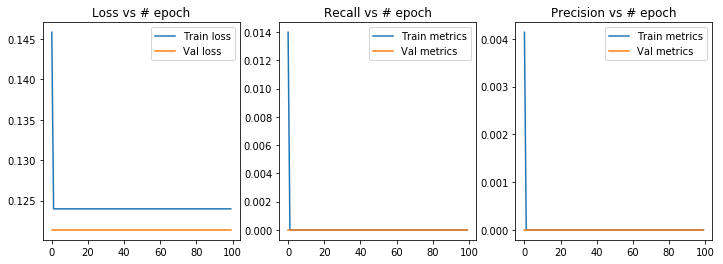

In [78]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(132)
plt.plot(history.history['recall'], label='Train metrics')
plt.plot(history.history['val_recall'], label='Val metrics')
plt.title("Recall vs # epoch")
plt.legend()
plt.subplot(133)
plt.plot(history.history['precision'], label='Train metrics')
plt.plot(history.history['val_precision'], label='Val metrics')
plt.title("Precision vs # epoch")
plt.legend()

In [79]:
Y_pred = model.predict(X_test)
Y_pred.shape, Y_pred.min(), Y_pred.max()

((125L, 1L, 80L, 80L), 0.0, 0.0)

In [80]:
from sklearn.metrics import mean_absolute_error

y_test = Y_test.reshape((Y_test.shape[0], np.prod(Y_test.shape[1:])))
y_true = Y_pred.reshape((Y_pred.shape[0], np.prod(Y_pred.shape[1:])))

mean_absolute_error(y_true, y_test)

0.007530001

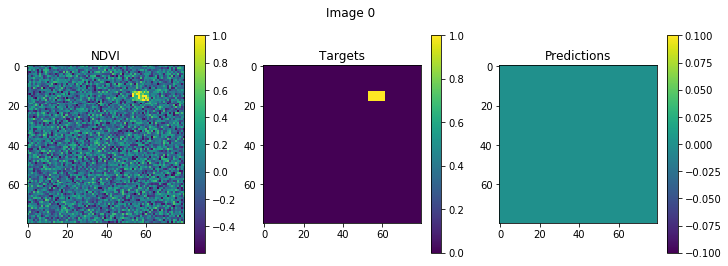

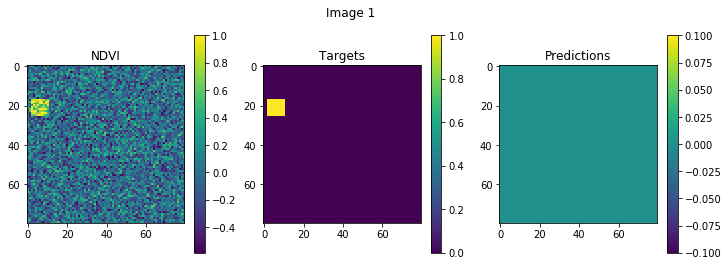

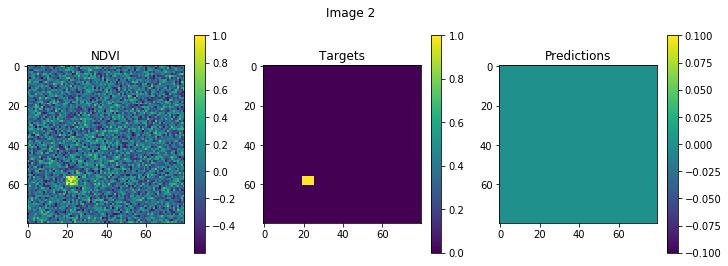

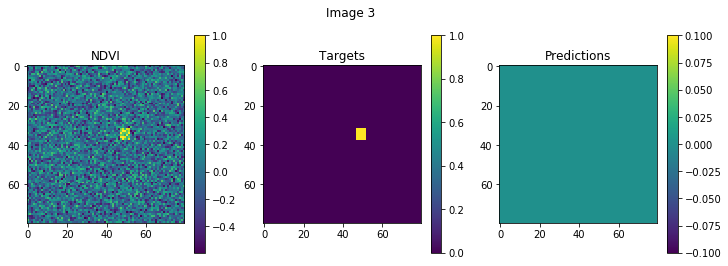

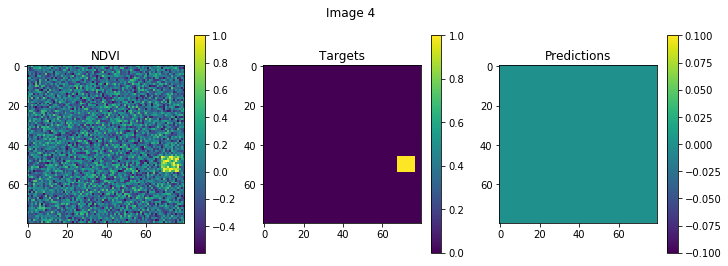

In [81]:
for j in range(5):
    plt.figure(figsize=(12,4))
    plt.suptitle("Image %i" % j)
    plt.subplot(131)
    ndvi = (X_test[j,3,:,:] - X_test[j,0,:,:]) / (X_test[j,3,:,:] + X_test[j,0,:,:])
    plt.imshow(ndvi, interpolation='none')
    plt.colorbar()
    plt.title("NDVI")
    plt.subplot(132)
    plt.imshow(Y_test[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Targets")
    plt.subplot(133)
    plt.imshow(Y_pred[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Predictions")

## Look inside the network

Let's take a look on feature maps created by the trained network

In [82]:
import keras.backend as K

def get_layer_output_f(layer_name, model):
    inputs = [K.learning_phase()] + model.inputs
    output_layer = model.get_layer(name=layer_name)
    outputs = output_layer.output
    return K.function(inputs, [outputs])
    
def compute_layer_output(input_data, layer_output_f):
    return layer_output_f([0] + [input_data])

def compute_layer_outputs(input_data, model, layer_output_f_dict={}):
    layer_outputs = []
    for layer in model.layers:
        if layer in model.input_layers or layer in model.output_layers:
            continue
        print layer.name
        if layer.name not in layer_output_f_dict:
            layer_output_f_dict[layer.name] = get_layer_output_f(layer.name, model)
        layer_outputs.append((layer.name, compute_layer_output(input_data, layer_output_f_dict[layer.name])))
    return layer_outputs

def display_layer_output(layer_name, layer_output, **kwargs):
    
    layer_output = layer_output[0]
    nc = layer_output.shape[1]
    n_cols = 4 if  nc > 4 else nc
    n_rows = max(int(np.floor(nc / n_cols)), 1)
    plt.suptitle("First output for layer %s : %i - %i" % (layer_name, 1, nc))
    for i in range(nc):
        plt.subplot(n_rows,n_cols,i+1)
        plt.imshow(layer_output[0,i,:,:], interpolation='none')   
        plt.axis('off')

In [83]:
layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(X_test[:1,:,:,:], model, layer_output_f_dict)

convolution2d_19
maxpooling2d_5
convolution2d_20
maxpooling2d_6
convolution2d_21
upsampling2d_5
merge_5
convolution2d_22
upsampling2d_6
merge_6
convolution2d_23


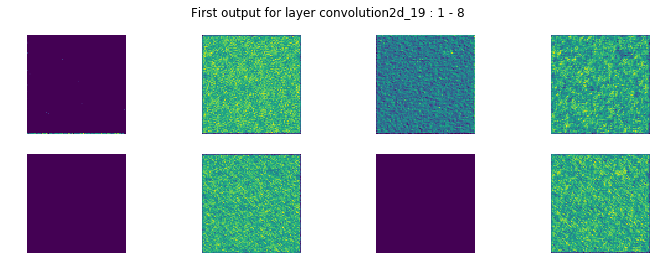

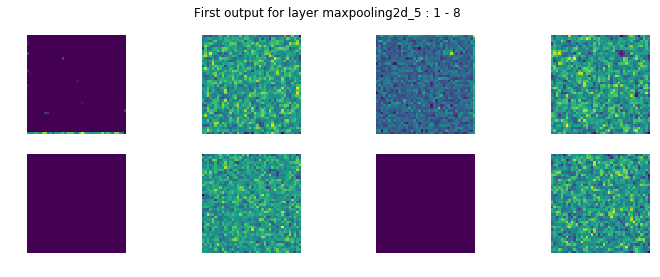

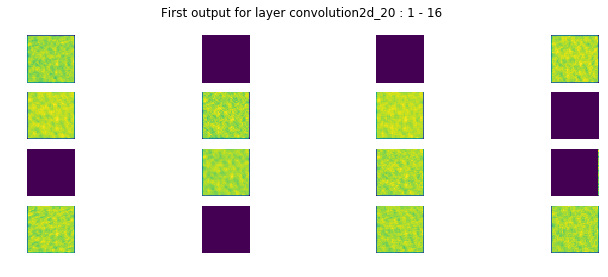

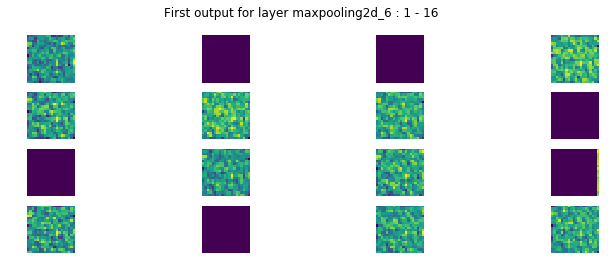

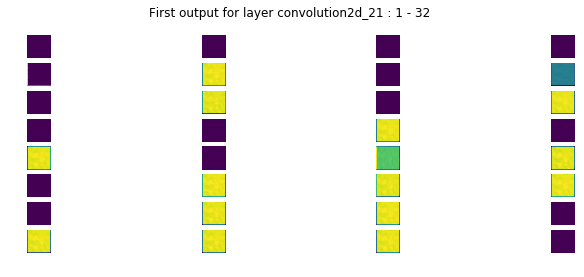

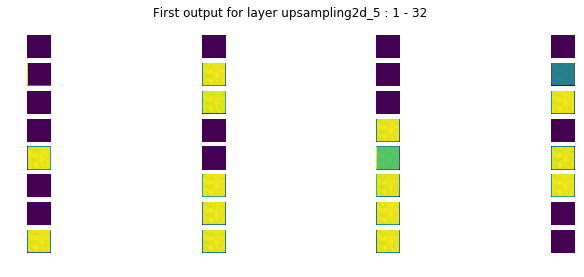

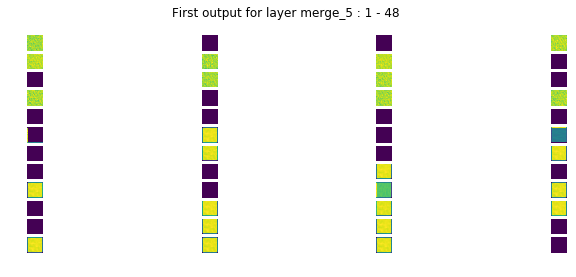

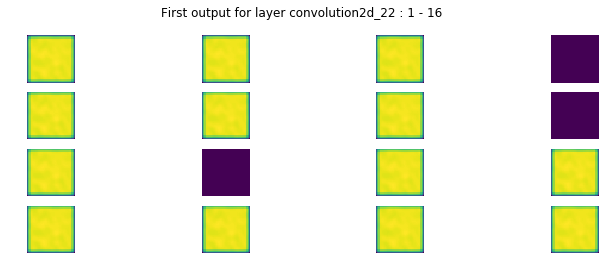

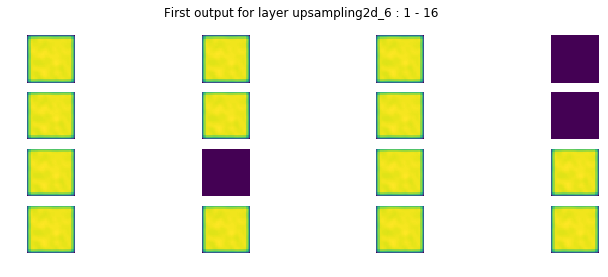

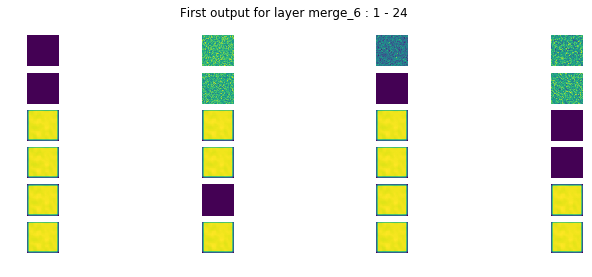

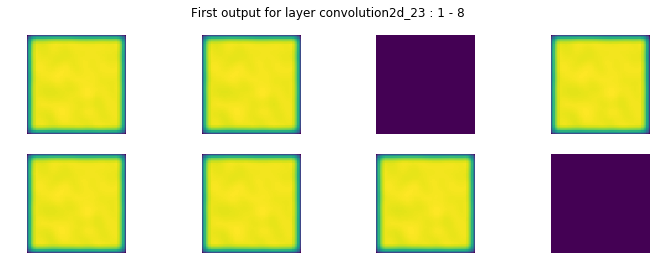

In [84]:
for layer_output in layer_outputs:
    plt.figure(figsize=(12,4))
    display_layer_output(*layer_output)

## Ratio function network architecture

Idea is to use 2d convolutional layers to mix channels and to create a numerator and denominator. Feature map obtained applying a 2d convolution is weighted sum of convolved image channels:

$$
f^a_{i,j}(I_{k}) = b^a + \sum_{k} conv(W^{a,k} I_{k})_{ij},
$$
where $a=0,...,\text{nb_filters}-1$, $i,j$ denotes pixel coordinates in the feature map, the sum over $k$ goes over all input image channels, from $0$ until $\text{nb_input_channels}-1$.

The number of weigths of a 2d convolutional layer is computed as `nb_filters * nb_input_channels * kernel_width * kernel_height`. There are `nb_filters * nb_input_channels` of matrices $W$.

Basic block to construct numerator and denominator, thus, writes as `Image -> Conv(1, s, s)(Image)`



In [221]:
max_power = 1

x_in = Input((n_channels, input_height, input_width), name='input')

def create_powers(input_layer, max_power, nb_layers=1, n_filters=5, kernel_size=3, name_prefix=''):
    # Create `max_power` of combinations [b + w*x_in]
    xs = []
    x = input_layer
    for i in range(max_power):
        for i in range(nb_layers):
            x = Convolution2D(n_filters, kernel_size, kernel_size, 
                              init='one', 
                              border_mode='same', 
                              name='%s_multiplier_%i' % (name_prefix, i))(x)        
        xs.append(x)

    # Merge multiply:
    if len(xs) > 1:
        x = merge([xs[0], xs[1]], mode='mul', name='%s_product_%i_%i' % (name_prefix, 0, 1))
        for i in range(max_power - 2):
            x = merge([x, xs[i+2]], mode='mul', name='%s_product_%i_%i' % (name_prefix, 0, i))
    else:
        x = xs[0]
    return x

# Create numerator & denominator
x_numerator = create_powers(x_in, max_power, nb_layers=1, n_filters=2, kernel_size=1, name_prefix='numerator')
x_numerator = Convolution2D(1, 1, 1, init='one', border_mode='same', name='numerator')(x_numerator)   
x_denominator = create_powers(x_in, max_power, nb_layers=1, n_filters=2, kernel_size=1, name_prefix='denominator')
x_denominator = Convolution2D(1, 1, 1, init='one', border_mode='same', name='denominator')(x_denominator)   

# Divide
def division(list_of_tensors): 
    return list_of_tensors[0] / (list_of_tensors[1] + K.epsilon())

x = merge([x_numerator, x_denominator], mode=division, output_shape=x_numerator._keras_shape[1:], name='fraction')

x = Activation('sigmoid')(x)

x_out = x

model = Model(input=x_in, output=x_out)

In [222]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 4, 80, 80)     0                                            
____________________________________________________________________________________________________
numerator_multiplier_0 (Convolut (None, 2, 80, 80)     10          input[0][0]                      
____________________________________________________________________________________________________
denominator_multiplier_0 (Convol (None, 2, 80, 80)     10          input[0][0]                      
____________________________________________________________________________________________________
numerator (Convolution2D)        (None, 1, 80, 80)     3           numerator_multiplier_0[0][0]     
___________________________________________________________________________________________

In [223]:
# x = np.arange(0.0, 1.0, 0.01)
# plt.figure()
# plt.plot(x, -np.log(x * 100.0 + 1.0))

In [231]:
def K_jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    y_true = K.cast(y_true, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def K_jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def K_jaccard_loss(y_true, y_pred):
    jac = K_jaccard_coef(y_true, y_pred)
    return - K.log(1.0 + jac)

model.compile(loss=K_jaccard_loss, optimizer='nadam', metrics=['recall', 'precision', 'accuracy'])

In [232]:
Y_true = K.variable(Y_test)
y_pred = model.predict(X_test)
Y_pred = K.variable(y_pred)
print Y_true._keras_shape, Y_pred._keras_shape

res = K_jaccard_coef(Y_true, Y_pred)

(125L, 1L, 80L, 80L) (125L, 1L, 80L, 80L)


In [233]:
res.eval()

array(0.007509248796850443, dtype=float32)

In [240]:
y_pred[1,0,:,:]

array([[ 0.7310586 ,  0.7310586 ,  0.7310586 , ...,  0.7310586 ,
         0.7310586 ,  0.7310586 ],
       [ 0.7310586 ,  0.7310586 ,  0.7310586 , ...,  0.7310586 ,
         0.7310586 ,  0.7310586 ],
       [ 0.7310586 ,  0.7310586 ,  0.7310586 , ...,  0.73105854,
         0.7310586 ,  0.7310586 ],
       ..., 
       [ 0.7310586 ,  0.7310586 ,  0.7310586 , ...,  0.7310586 ,
         0.7310586 ,  0.7310586 ],
       [ 0.7310586 ,  0.73105854,  0.7310586 , ...,  0.7310586 ,
         0.7310586 ,  0.7310586 ],
       [ 0.7310586 ,  0.7310586 ,  0.73105854, ...,  0.7310586 ,
         0.7310586 ,  0.7310586 ]], dtype=float32)

In [201]:
batch_size=16
history = model.fit(X_train, Y_train, nb_epoch=100, batch_size=batch_size, validation_data=[X_test, Y_test], shuffle=True, verbose=0)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\victor.fomin\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64\lock_dir\lock


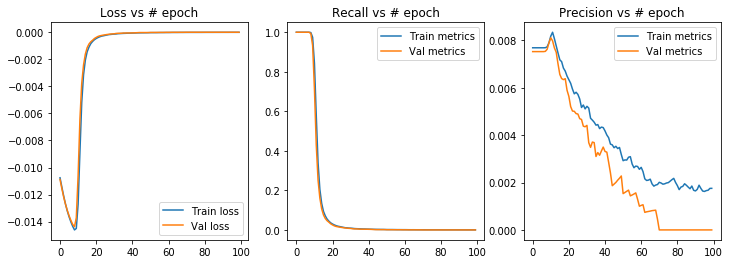

In [220]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(132)
plt.plot(history.history['recall'], label='Train metrics')
plt.plot(history.history['val_recall'], label='Val metrics')
plt.title("Recall vs # epoch")
plt.legend()
plt.subplot(133)
plt.plot(history.history['precision'], label='Train metrics')
plt.plot(history.history['val_precision'], label='Val metrics')
plt.title("Precision vs # epoch")
plt.legend()

In [234]:
Y_pred = model.predict(X_test)
Y_pred.shape, Y_pred.min(), Y_pred.max()

((125L, 1L, 80L, 80L), 0.73105854, 0.7310586)

In [235]:
from sklearn.metrics import mean_absolute_error

y_test = Y_test.reshape((Y_test.shape[0], np.prod(Y_test.shape[1:])))
y_true = Y_pred.reshape((Y_pred.shape[0], np.prod(Y_pred.shape[1:])))

mean_absolute_error(y_true, y_test)

0.72757852

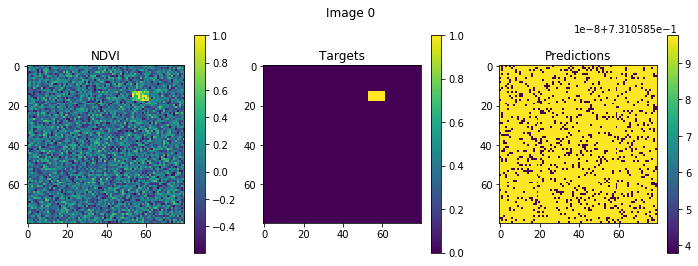

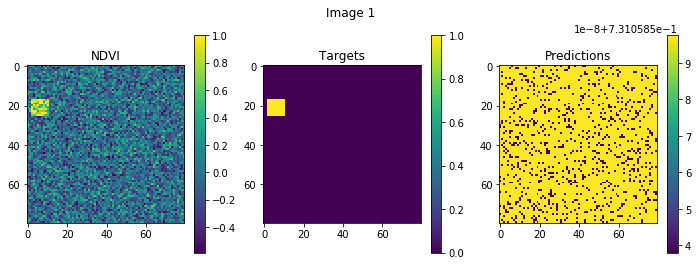

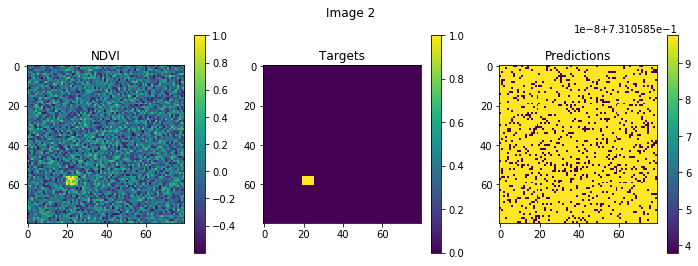

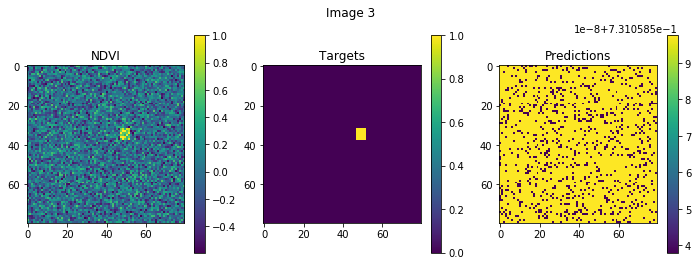

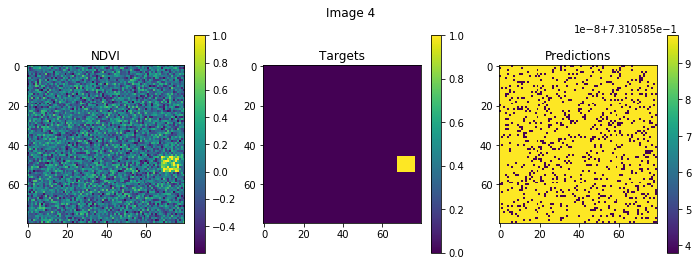

In [236]:
for j in range(5):
    plt.figure(figsize=(12,4))
    plt.suptitle("Image %i" % j)
    plt.subplot(131)
    ndvi = (X_test[j,3,:,:] - X_test[j,0,:,:]) / (X_test[j,3,:,:] + X_test[j,0,:,:])
    plt.imshow(ndvi, interpolation='none')
    plt.colorbar()
    plt.title("NDVI")
    plt.subplot(132)
    plt.imshow(Y_test[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Targets")
    plt.subplot(133)
    plt.imshow(Y_pred[j,0,:,:], interpolation='none')
    plt.colorbar()
    plt.title("Predictions")

## Look inside the network

Let's take a look on feature maps created by the trained network

In [93]:
layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(X_test[:1,:,:,:], model, layer_output_f_dict)

numerator_multiplier_0
denominator_multiplier_0


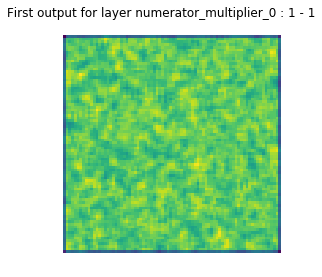

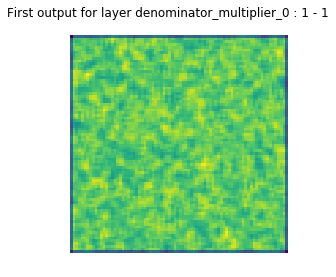

In [94]:
for layer_output in layer_outputs:
    plt.figure(figsize=(12,4))
    display_layer_output(*layer_output)

### Display weights of the trained network

(1,)
(1,)


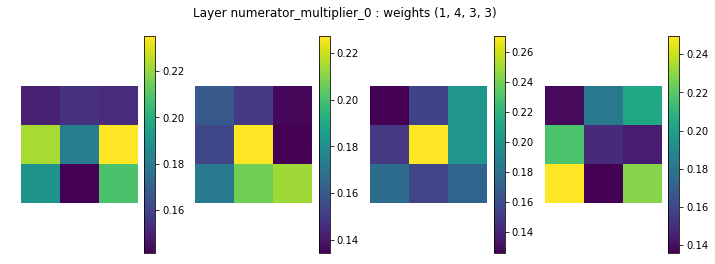

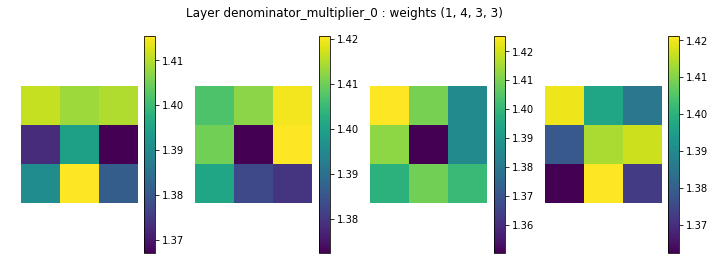

In [68]:
layers = list(model.layers)
layers.remove(model.input_layers[0])
for layer in layers:
    if not hasattr(layer, 'W'):
        continue
    weights = layer.W.eval()
#     b = layer.b.eval()
    
    plt.figure(figsize=(12, 4))
    plt.suptitle("Layer {} : weights {}".format(layer.name, weights.shape))
    
    nc = weights.shape[1]
    n_cols = 4 if  nc > 4 else nc
    n_rows = max(int(np.floor(nc / n_cols)), 1)
    for i in range(nc):
        plt.subplot(n_rows,n_cols,i+1)
        plt.imshow(weights[0,i,:,:], interpolation='none')   
        plt.axis('off')
        plt.colorbar()
        
    plt.figure(figsize=(12, 4))
    plt.suptitle("Layer {} : bias {}".format(layer.name, b.shape))    

#     nc = b.shape[1]
#     n_cols = 4 if  nc > 4 else nc
#     n_rows = max(int(np.floor(nc / n_cols)), 1)
#     for i in range(nc):
#         plt.subplot(n_rows,n_cols,i+1)
#         plt.imshow(b[0,i,:,:], interpolation='none')   
#         plt.axis('off')
#         plt.colorbar()
